## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 9 марта 2024**

**Дедлайн: 24 марта 23:59 MSK**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [ ]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
print(pd.to_datetime(df['last_watch_dt']).max(), pd.to_datetime(df['last_watch_dt']).min())

2021-08-22 00:00:00 2021-03-13 00:00:00


In [ ]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
3987719,366549,2657,130,988,0.0
1630559,452852,13865,109,4340,68.0
145118,151209,14310,32,10266,100.0
5012025,448281,12225,55,1413,1.0
4144970,1097197,4151,152,1153,13.0


Сделаем разбиение по времени

<Axes: >

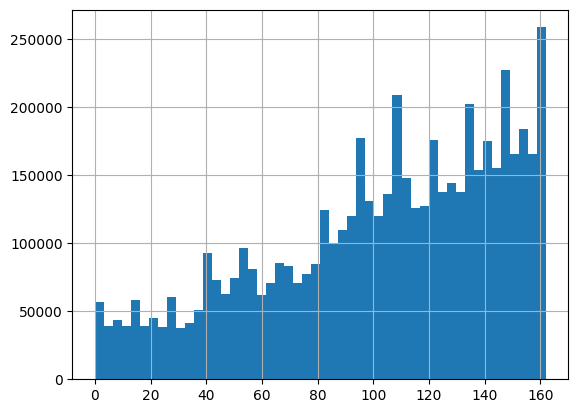

In [ ]:
df.last_watch_dt.hist(bins=50)

In [ ]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [ ]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [ ]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [ ]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
127,375013,6907,104,8079,100.0
131,470881,11800,100,909,19.0
144,196855,11754,148,86,1.0
160,59968,3734,146,9445,100.0
194,669687,12981,86,5928,64.0


In [ ]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

,user_id,train_interactions
0,21,"[(10283, 7), (15997, 15), (12261, 17), (4345, ..."
1,53,"[(13865, 110), (7571, 110), (10440, 115), (161..."
2,120,"[(15297, 151), (6809, 151), (1000, 151)]"
3,157,"[(10440, 142), (15297, 143), (4713, 151), (124..."
4,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11..."


In [ ]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,21,"[(10283, 7), (15997, 15), (12261, 17), (4345, ...","[(12360, 155), (13787, 158), (14488, 158)]"
1,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158..."
2,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]"
3,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]"
4,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213..."


In [ ]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,21,"[(10283, 7), (15997, 15), (12261, 17), (4345, ...","[(12360, 155), (13787, 158), (14488, 158)]","[741, 5672, 4892]"
1,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158...","[741, 5672, 4892]"
2,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]","[741, 5672, 4892]"
3,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[741, 5672, 4892]"
4,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213...","[741, 5672, 4892]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [ ]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)

    mask = np.isin(predictions, gt_items)[:topn]
    idx = np.arange(1, topn + 1)
    cum_sum = np.cumsum(mask) / idx
    ap = np.sum(cum_sum * mask) / min(topn, len(gt_items))

    return ap

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)

    mask = np.isin(predictions, gt_items)[:topn]
    rr = 1 / (np.argmax(mask) + 1) if np.any(mask) else 0

    return rr

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)

    hr = int(np.any(np.isin(predictions[:topn], gt_items)))

    return hr


In [ ]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать.

In [ ]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [ ]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0016333333333333332, 'mrr': 0.0037, 'hr': 0.0037}

In [ ]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,21,"[(10283, 7), (15997, 15), (12261, 17), (4345, ...","[(12360, 155), (13787, 158), (14488, 158)]","[741, 5672, 4892]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158...","[741, 5672, 4892]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]","[741, 5672, 4892]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[741, 5672, 4892]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213...","[741, 5672, 4892]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [ ]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06800936248110355, 'mrr': 0.11802956349206349, 'hr': 0.2722}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [ ]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        counts = {}
        for _, row in df.iterrows():
            for item, t in row[col]:
                if 152 - t > self.min_window:
                  continue
                elif item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop_w = TopPopularWeighted()
toppop_w.fit(joined)

joined['toppopular_weighted_recs'] = toppop_w.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_weighted_recs
0,21,"[(10283, 7), (15997, 15), (12261, 17), (4345, ...","[(12360, 155), (13787, 158), (14488, 158)]","[741, 5672, 4892]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 341, 7793, 4151, 13865, 1..."
1,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158...","[741, 5672, 4892]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 341, 7793, 4151, 13865, 1..."
2,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]","[741, 5672, 4892]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 341, 7793, 4151, 13865, 1..."
3,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[741, 5672, 4892]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 341, 7793, 4151, 13865, 1..."
4,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213...","[741, 5672, 4892]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 341, 7793, 4151, 13865, 1..."


Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

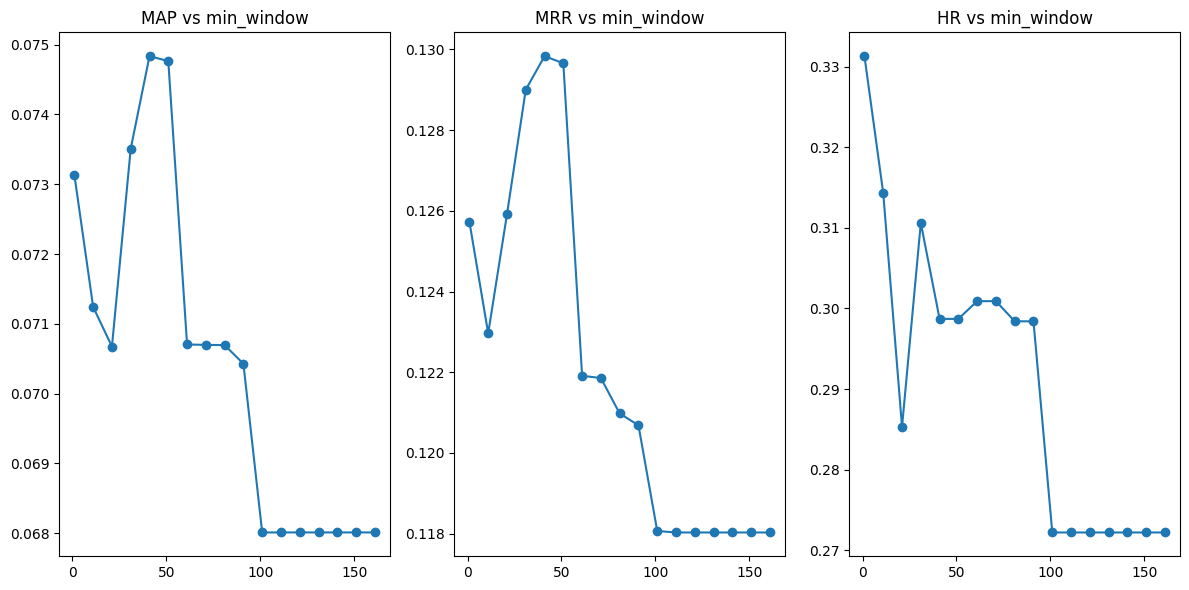

In [ ]:
mins = range(1, df['last_watch_dt'].max(), 10)
aps, rrs, hrs = [], [], []

for min_window in mins:
    toppop_w = TopPopularWeighted(min_window=min_window)
    toppop_w.fit(joined)
    joined['toppopular_weighted_recs'] = toppop_w.predict(joined)
    metrics = evaluate_recommender(joined, 'toppopular_weighted_recs')
    aps.append(metrics['map'])
    rrs.append(metrics['mrr'])
    hrs.append(metrics['hr'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(mins, aps, marker='o')
plt.title('MAP vs min_window')

plt.subplot(1, 3, 2)
plt.plot(mins, rrs, marker='o')
plt.title('MRR vs min_window')

plt.subplot(1, 3, 3)
plt.plot(mins, hrs, marker='o')
plt.title('HR vs min_window')

plt.tight_layout()
plt.show()


Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** Если окно маленькое, то реки будут нерепрезентативными и некачественными. Если большое - неактуальными. Нужно выбирать золотую середину в зависимости от данных и датасета

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике.

In [ ]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

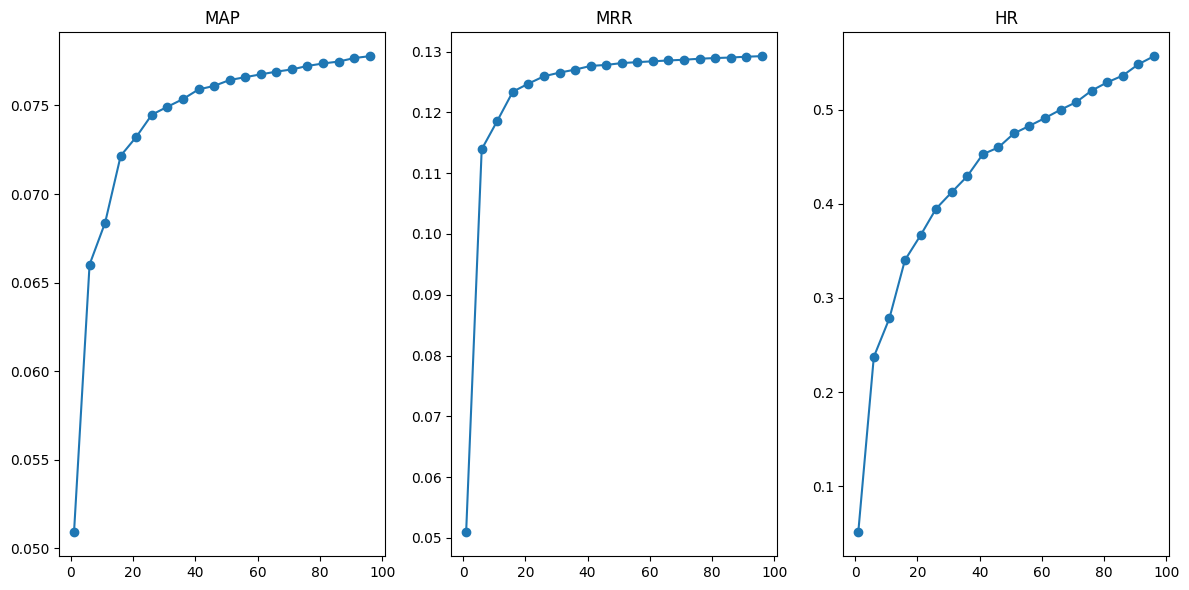

In [ ]:
aps, rrs, hrs = [], [], []

kk = range(1, 101, 5)

for k in kk:

    metric_values = []

    for idx, row in joined.iterrows():
        gt_items = [x[0] for x in row['test_interactions']]
        predictions = row['toppopular_recs']

        ap = ap_metric(gt_items, predictions, topn = k)
        rr = rr_metric(gt_items, predictions, topn = k)
        hr = hr_metric(gt_items, predictions, topn = k)

        metric_values.append((ap, rr, hr))

    metrics = {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

    aps.append(metrics['map'])
    rrs.append(metrics['mrr'])
    hrs.append(metrics['hr'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(kk, aps, marker='o')
plt.title('MAP')

plt.subplot(1, 3, 2)
plt.plot(kk, rrs, marker='o')
plt.title('MRR')

plt.subplot(1, 3, 3)
plt.plot(kk, hrs, marker='o')
plt.title('HR')

plt.tight_layout()
plt.show()


Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:** Все кроме МАПА: увеличение К не может уронить хитрейт (если попали и так, то 1 не может стать 0) и рр (там мы смотрим на первую позицию угаданного айтема - опять же если угадали, то ничего не меняется)
МАП по идее не является монотонной, так как если мы насыпем в конце неправильные айтемы, то результат размоется

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:** РР выходит на плато в районе к=17 - после этого позиция первого угаданного айтема не меняется. Хитрейт продолжает расти - чем больше мы насыпем рекомендаций, тем больше вероятность попасть в true айтемы. МАП растет из-за специфики датасета - если рекомендовать много, то доля хороших фильмов вырастает

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:** 2 и 3 норм, 1 по идее не должен расти, но такова специфика кина: если порекомендовать мало, то велик шанс не попасть, а если насыпать очень много фильмов, то МАП вырастет, тк у пользователя много любимых фильмов (и они в среднем все довольно популярные)

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [ ]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

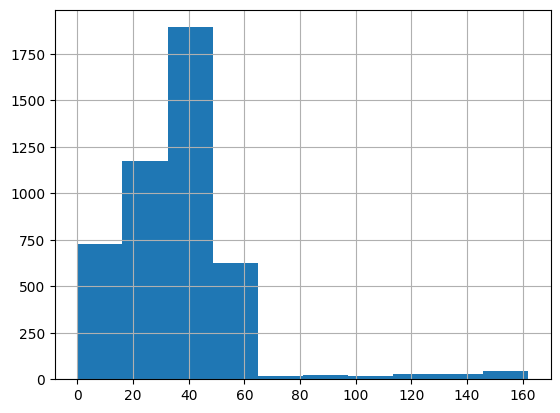

In [ ]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

1917


<Axes: >

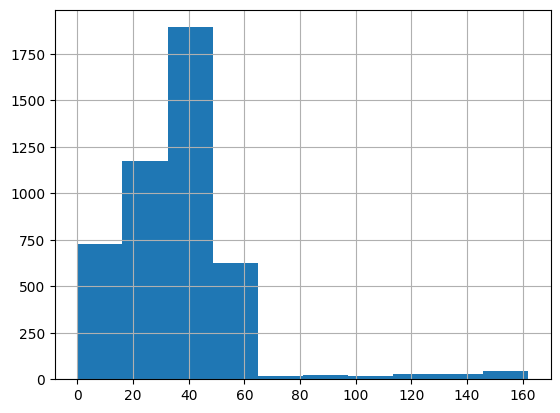

In [ ]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

<ipython-input-79-f49f80355a35>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(int('24'+f'{n+1}'))


11310 Аладдин
9169 Взаперти
16509 Мост
5732 Тайное влечение
14901 Небеса подождут
12324 Патруль: По законам улиц
10772 Зелёная книга
10942 Мстители


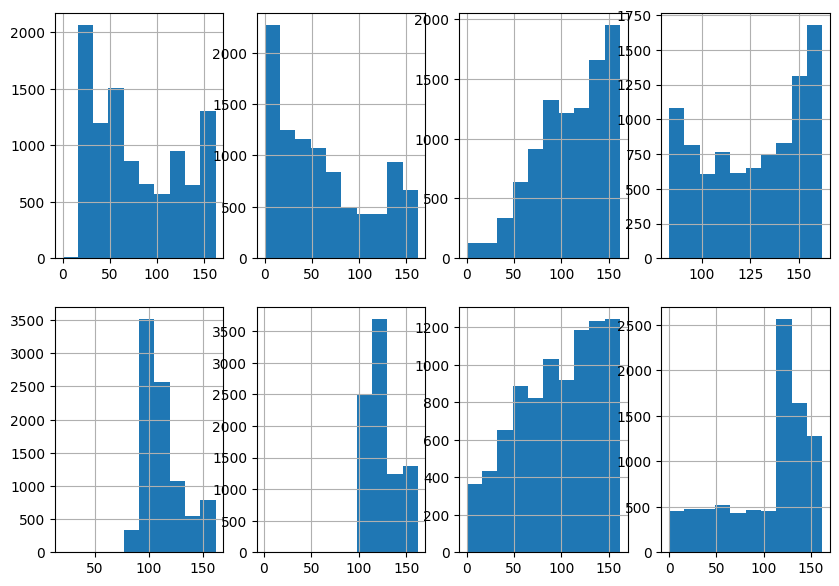

In [ ]:
# буду перебирать i и рассматривать результаты
i = 6
f, axs = plt.subplots(2, 2, figsize=(3, 30))
f.set_figheight(7)
f.set_figwidth(10)
for n, film in enumerate(popular_items[i*10:(i*10)+8]):
  plt.subplot(int('24'+f'{n+1}'))
  interactions = df.loc[df.item_id==film].copy()
  name = items.loc[items.item_id==film].title.values[0]
  print(film, name)
  interactions.last_watch_dt.hist()
  plt.show;

Подслушано


<Axes: >

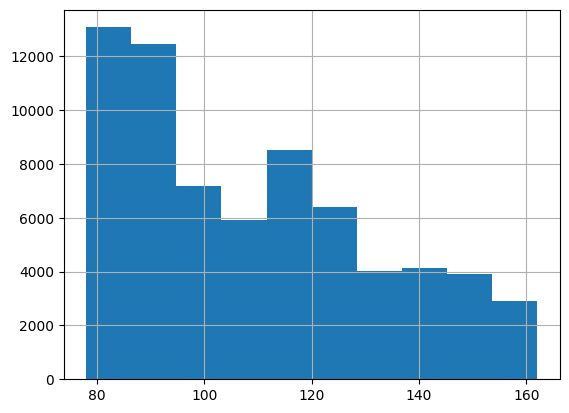

In [ ]:
interactions = df.loc[df.item_id==2657].copy()
name = items.loc[items.item_id==2657].title.values[0]
print(name)
interactions.last_watch_dt.hist()
# Сериал вышел, привлек внимание, но потом скатился

Моана


<Axes: >

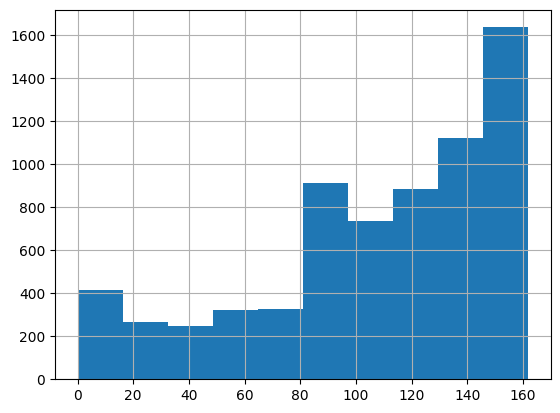

In [ ]:
interactions = df.loc[df.item_id==10761].copy()
name = items.loc[items.item_id==10761].title.values[0]
print(name)
interactions.last_watch_dt.hist()
# Мульт вышел давно и не был особо популярен, но со временем интерес подогрелся, мб дело в сезоне (ближе к лету)

Хрустальный


<Axes: >

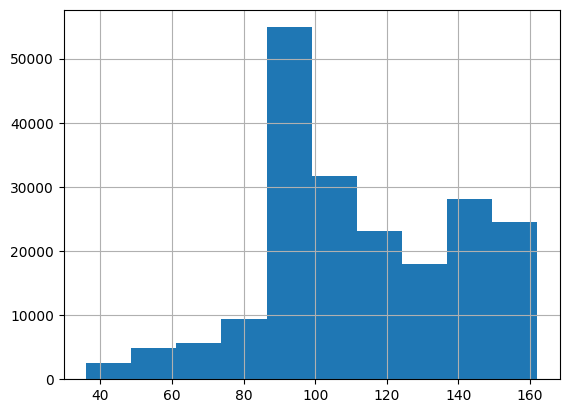

In [ ]:

interactions = df.loc[df.item_id==10440].copy()
name = items.loc[items.item_id==10440].title.values[0]
print(name)
interactions.last_watch_dt.hist()

# Cкачок просмотров - мб рекламная кампания, мб стал доступен со скидкой или бесплатно

Мстители: Война бесконечности


<Axes: >

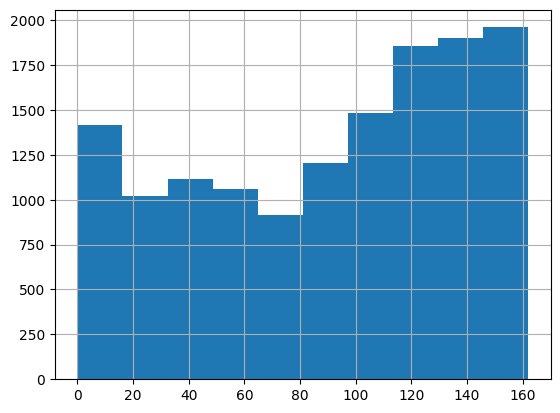

In [ ]:

interactions = df.loc[df.item_id==7626].copy()
name = items.loc[items.item_id==7626].title.values[0]
print(name)
interactions.last_watch_dt.hist()

# На фоне очередного марвеловского фильма все решили вспомнить старое

Аладдин


<Axes: >

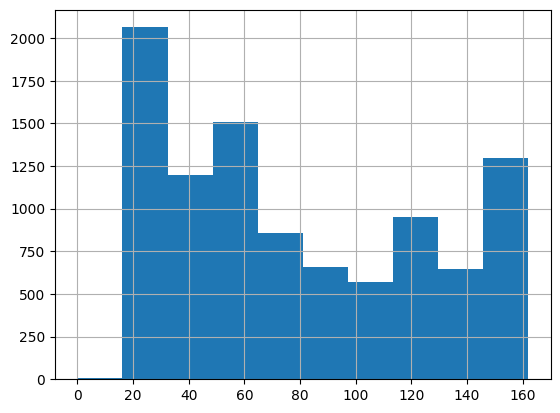

In [ ]:

interactions = df.loc[df.item_id==11310].copy()
name = items.loc[items.item_id==11310].title.values[0]
print(name)
interactions.last_watch_dt.hist()

# Фильм прорекламировали, но в первые дни он никому не зашел - поэтому
# из-за плохих отзывов его смотрели все реже и реже

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [ ]:
df['item_id'].value_counts() < 5

10440    False
15297    False
9728     False
13865    False
4151     False
         ...  
8076      True
8954      True
15664     True
818       True
10542     True
Name: item_id, Length: 15706, dtype: bool

In [ ]:
df

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,59,4250,72.0
1,699317,1659,77,8317,100.0
2,656683,7107,57,10,0.0
3,864613,7638,114,14483,100.0
4,964868,9506,48,6725,100.0
...,...,...,...,...,...
5476245,786732,4880,60,753,0.0
5476246,648596,12225,153,76,0.0
5476247,546862,9673,31,2308,49.0
5476248,697262,15297,160,18307,63.0


In [ ]:
def filter_column(df, col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """

    counts = df[col].value_counts()
    df = df[df[col].isin(counts[counts >= min_freq].index)]

    return df

In [ ]:
def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """

    df_new = df
    for i in range(10): # лень придумывать, можно было через while, но у меня колаб упал из-за какой-то опечатки
      for col in cols:
        if df_new[col].value_counts().min() >= 5:
          continue
        df_new = filter_column(df_new, col, min_freq)
    return df_new


In [ ]:
filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'])

In [ ]:
item2id = {k:v for v, k in enumerate(filtered_train.item_id.unique())}
user2id = {k:v for v, k in enumerate(filtered_train.user_id.unique())}

id2item = {k:v for v, k in item2id.items()}
id2user = {k:v for v, k in user2id.items()}

filtered_train['user_id'] = filtered_train.user_id.apply(lambda x: user2id[x])
filtered_train['item_id'] = filtered_train.item_id.apply(lambda x: item2id[x])


In [ ]:
filtered_train

,user_id,item_id,last_watch_dt,total_dur,watched_pct
127,0,0,104,8079,100.0
144,1,1,148,86,1.0
194,2,2,86,5928,64.0
244,3,3,26,6133,97.0
251,4,4,44,9308,100.0
...,...,...,...,...,...
5475915,274,78,140,79,2.0
5476036,4711,42,110,8020,100.0
5476038,1704,2354,105,23,0.0
5476077,921,920,29,155,3.0


In [ ]:
filtered_train = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
4903488,3972,676,111,851,10.0
2622932,1585,1257,135,5667,100.0
923626,4081,247,95,40134,11.0
1161212,1017,841,103,136541,100.0
1922621,3989,967,134,6202,100.0


In [ ]:
item2id = {k:v for v, k in enumerate(filtered_train.item_id.unique())}
user2id = {k:v for v, k in enumerate(filtered_train.user_id.unique())}

In [ ]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<5884x3108 sparse matrix of type '<class 'numpy.float64'>'
	with 107764 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра.

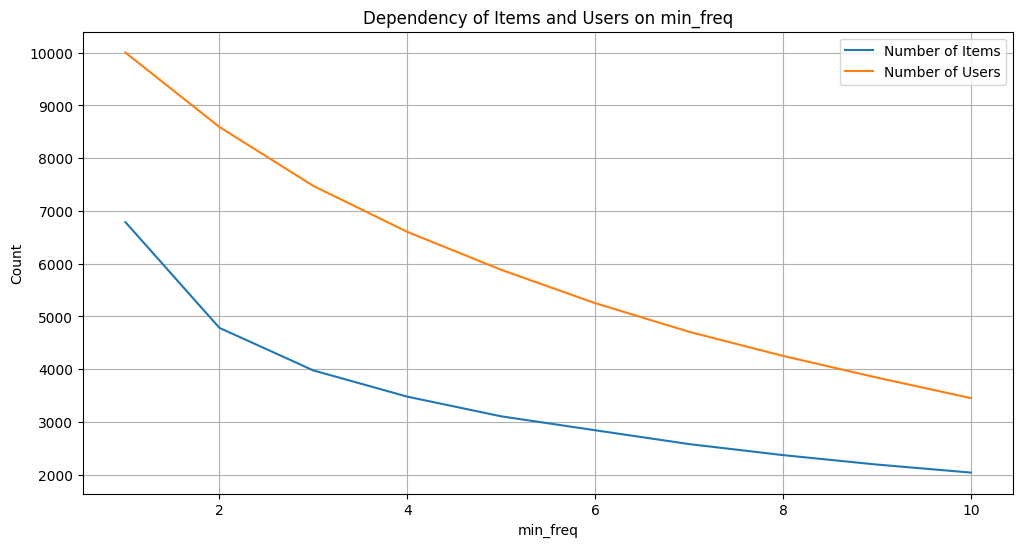

In [ ]:
min_freq_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

item_counts = []
user_counts = []

for min_freq in min_freq_values:
    filtered_df = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq)
    item_counts.append(filtered_df['item_id'].nunique())
    user_counts.append(filtered_df['user_id'].nunique())

plt.figure(figsize=(12, 6))
plt.plot(min_freq_values, item_counts, label='Number of Items')
plt.plot(min_freq_values, user_counts, label='Number of Users')
plt.xlabel('min_freq')
plt.ylabel('Count')
plt.title('Dependency of Items and Users on min_freq')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Логично)

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k.

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [ ]:
class EASE:
    def __init__(self, lmbd=0.5):
        self.lmbd = lmbd
        self.W = None

    def fit(self, X):
        C = X.T.dot(X)
        diag_ind = np.diag_indices(C.shape[0])
        C[diag_ind] += self.lmbd
        P = np.linalg.inv(C.toarray())
        B = P / -np.diag(P)
        B[diag_ind] = 0
        self.W = B

    def predict(self, X, user_id = None, topn=10):
        if user_id == None:
          scores = X.dot(self.W)
          scores[X.nonzero()] = -np.inf
        else:
          scores = X[user_id].dot(self.W)
          scores[X[user_id].nonzero()] = -np.inf
        top_items = np.argsort(scores)[::-1][:topn]

        return top_items

In [ ]:
ease_model = EASE(lmbd=0.5)
ease_model.fit(matrix)

In [ ]:
ease_model.W

array([[ 0.00000000e+00,  4.29065858e-02, -3.80092010e-02, ...,
        -3.25309931e-03, -7.20970104e-03,  2.76728138e-03],
       [ 1.62152526e-02,  0.00000000e+00,  5.31643920e-03, ...,
        -4.55059860e-03, -1.95989312e-03, -4.63888723e-03],
       [-6.49286825e-03,  2.40308394e-03,  0.00000000e+00, ...,
        -1.34197734e-05, -1.14022305e-03, -8.17946937e-04],
       ...,
       [-3.11128669e-02, -1.15162604e-01, -7.51346109e-04, ...,
         0.00000000e+00,  9.74872393e-04,  1.41002247e-02],
       [-9.75272845e-02, -7.01522337e-02, -9.02923263e-02, ...,
         1.37884021e-03,  0.00000000e+00, -8.29233623e-03],
       [ 1.61531111e-02, -7.16501189e-02, -2.79498924e-02, ...,
         8.60569962e-03, -3.57825171e-03,  0.00000000e+00]])

In [ ]:
ease_model.predict(matrix, topn = k).shape

(5, 3108)

In [ ]:
matrix

<5884x3108 sparse matrix of type '<class 'numpy.float64'>'
	with 107764 stored elements in COOrdinate format>

In [ ]:
matrix.shape

(5884, 3108)

In [ ]:

k_values = [5, 10, 20]
for k in k_values:
  joined[f'toppop_{k}'] = toppop.predict(joined, topn = k)
  evaluate_recommender(joined, model_preds=f'toppop_{k}')
  joined[f'ease_{k}'] = ease_model.predict(matrix, topn = k)
  evaluate_recommender(joined, model_preds=f'ease_{k}')

In [ ]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=100):

 # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)

    return B

w = fit_ease(matrix)

CPU times: user 4.29 s, sys: 350 ms, total: 4.64 s
Wall time: 2.62 s


In [ ]:
w.shape

(3108, 3108)

Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [ ]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

In [ ]:
def get_preds(x, item2id, id2item, topn = 100):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:topn]

    return decoded


kk = [5, 10, 20]
for k in kk:
  joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, k))
  joined['toppopular_recs'] = toppop.predict(joined, topn = k)
  print(evaluate_recommender(joined, model_preds='ease_preds'))
  print(evaluate_recommender(joined, model_preds='toppopular_recs'))

{'map': 9.166666666666667e-05, 'mrr': 0.000275, 'hr': 0.0008}
{'map': 0.06403469444444444, 'mrr': 0.11026500000000002, 'hr': 0.2155}
{'map': 9.50839947089947e-05, 'mrr': 0.0003649603174603175, 'hr': 0.0015}
{'map': 0.06800936248110355, 'mrr': 0.11802956349206349, 'hr': 0.2722}
{'map': 0.00016203467898740582, 'mrr': 0.0005565093746982291, 'hr': 0.0044}
{'map': 0.07256531419787247, 'mrr': 0.12395763617531418, 'hr': 0.3505}


Сделайте выводы — какой алгоритм работает лучше?

**Ответ:** EASE без файнтьюнинга справился хуже (отвратительно), посмотрим в следующем задании

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

ValueError: x and y must have same first dimension, but have shapes (17,) and (27,)

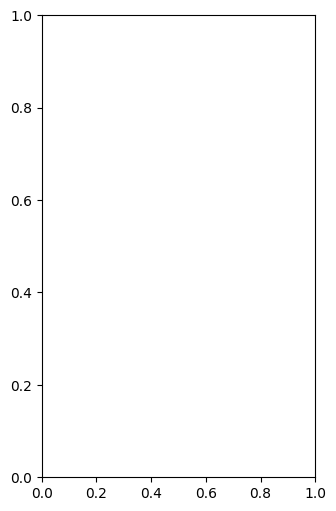

In [ ]:
for L in [0.01, 0.1, 1, 10, 100, 1000, 10000]:


    w = fit_ease(matrix, reg_weight=L)
    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
    metrics = evaluate_recommender(joined, model_preds='ease_preds')

    aps.append(metrics['map'])
    rrs.append(metrics['mrr'])
    hrs.append(metrics['hr'])


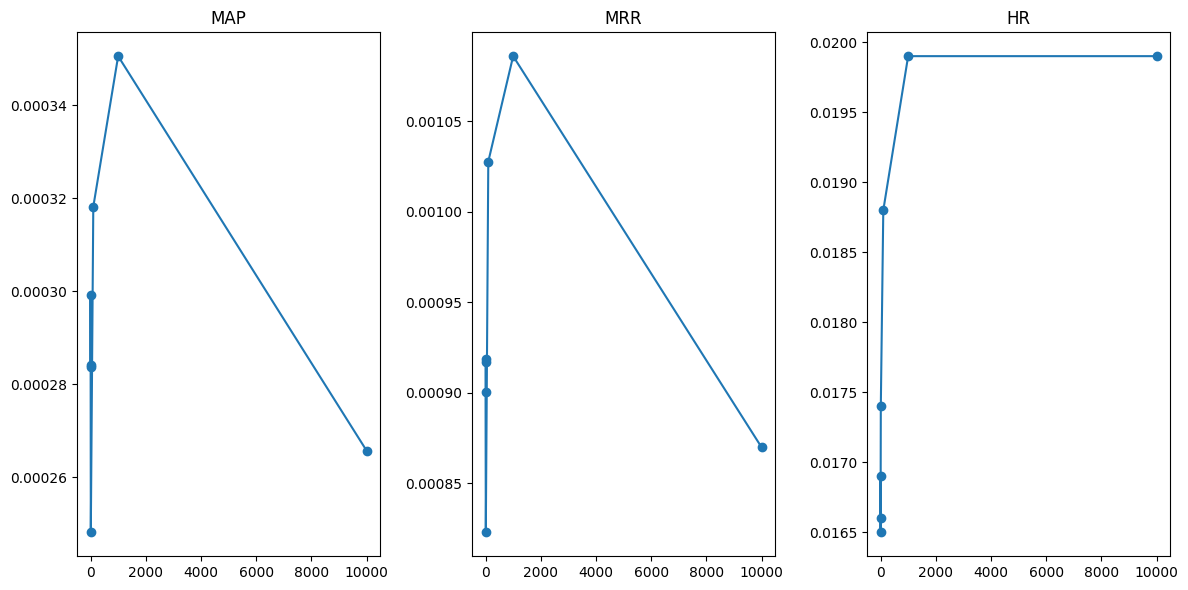

In [ ]:

L = [0.01, 0.1, 1, 10, 100, 1000, 10000]

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(L, aps[-7:], marker='o')
plt.title('MAP')

plt.subplot(1, 3, 2)
plt.plot(L, rrs[-7:], marker='o')
plt.title('MRR')

plt.subplot(1, 3, 3)
plt.plot(L, hrs[-7:], marker='o')
plt.title('HR')

plt.tight_layout()
plt.show()


Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?


**Ответ:** Что-то в районе 1000

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** HR не падает при большом коэфе, так как регуляризация не мешает попасть хотя бы в один правильный айтем


**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.

In [ ]:
# your code here

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**